In [1]:
# FEM numerical solution of the IBVP for the heat equation:
# u_t = \Delta u, (x,y) + f \in \Omega = Cat's head
# f is set to be zero, but a template for a nonzero f is encoded
# u(left eye bdry,t) = 0;  U(right_eye_bdry,t) = 1
# du/dn = 0 on the outer bdry
# u(x,t=0) = 10*exp(-4*((x(:,1) - 1.5*xmean(1)).^2 + (x(:,2) - 0.5*xmean(2)).^2))

from distmesh import *
import numpy as np
import math
import matplotlib.pyplot as plt
import csv 
import scipy

[[0.86601278 0.50002187]
 [0.74993439 1.29907598]
 [0.25875807 0.96594216]]
[[-0.25890441  0.96590295]
 [-0.75013121  1.29896234]
 [-0.86608853  0.49989065]]
count =  200 displacement =  0.015608320000333376
count =  400 displacement =  0.0045811230769996734
count =  600 displacement =  0.001242787402782448
count =  800 displacement =  0.0029473421498481577


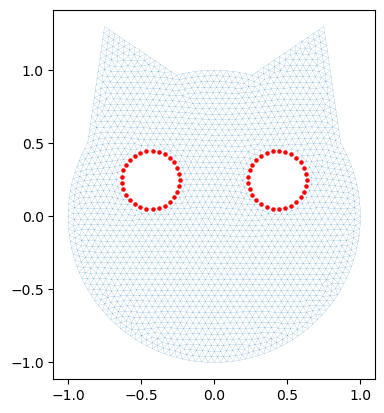

In [2]:
# trangulate Cat's head
n = 144
t = np.linspace(0,2*np.pi*(n/(n+1)),n)
rad = 1.0
h0 = rad*2*np.pi/n # the desired side of mesh triangles

pface = np.concatenate((np.reshape(rad*np.cos(t),(n,1)),np.reshape(rad*np.sin(t),(n,1))),axis = 1)
# indexes of angle values for defining ears
j0 = int(np.round(2*n/24))
j1 = int(np.round(4*n/24))
j2 = int(np.round(5*n/24)) 
j3 = int(np.round(7*n/24))
j4 = int(np.round(8*n/24))
j5 = int(np.round(10*n/24))

# right ear
rad_ear = 1.5*rad
right_ear_tip = rad_ear*np.array([np.cos(t[j1]),np.sin(t[j1])])
right_ear = np.array([rad*np.array([np.cos(t[j0]),np.sin(t[j0])]),right_ear_tip,rad*np.array([np.cos(t[j2]),np.sin(t[j2])])])
print(right_ear)

# left ear
left_ear_tip = rad_ear*np.array([np.cos(t[j4]),np.sin(t[j4])])
left_ear = np.array([rad*np.array([np.cos(t[j3]),np.sin(t[j3])]),left_ear_tip,rad*np.array([np.cos(t[j5]),np.sin(t[j5])])])
print(left_ear)

# eyes
rad_eye_center = 0.5*rad
rad_eye = 0.2*rad

Neye = int(np.round(2*np.pi*rad_eye/h0))
t_eye = np.linspace(0,2*np.pi*(Neye-1)/Neye,Neye)
right_eye = np.concatenate((np.reshape(rad_eye_center*np.cos(t[j0])+rad_eye*np.cos(t_eye),\
                                       (Neye,1)),np.reshape(rad_eye_center*np.sin(t[j0])\
                                                            +rad_eye*np.sin(t_eye),(Neye,1))),axis = 1) 
left_eye = np.concatenate((np.reshape(rad_eye_center*np.cos(t[j5])+rad_eye*np.cos(t_eye),\
                                       (Neye,1)),np.reshape(rad_eye_center*np.sin(t[j5])\
                                                            +rad_eye*np.sin(t_eye),(Neye,1))),axis = 1) 

# fixed points of the mesh
pfix = np.concatenate((pface[0:j0+1,:],np.reshape(right_ear_tip,(1,2)),pface[j2:j3+1,:],\
                       np.reshape(left_ear_tip,(1,2)),pface[j5:n,:],right_eye,left_eye),axis = 0)

# signed distance function for Cat's head
def dfunc(p):
    d0 = dcircle(p,0.0,0.0,rad) # face
    d1 = dcircle(p,rad_eye_center*np.cos(t[j0]),rad_eye_center*np.sin(t[j0]),rad_eye) # right eye
    d2 = dcircle(p,rad_eye_center*np.cos(t[j5]),rad_eye_center*np.sin(t[j5]),rad_eye) # left eye
    d3 = dpolygon(p,left_ear,3) # left ear
    d4 = dpolygon(p,right_ear,3) # right ear
    # (face \cup left_ear \cup right_ear) \backslash (left_eye \cup right_eye) 
    d = ddiff(dunion(dunion(d0,d3),d4),dunion(d1,d2))
    return d


xmin = np.min(pfix[:,0],axis = 0)
xmax = np.max(pfix[:,0],axis = 0)
ymin = np.min(pfix[:,1],axis = 0)
ymax = np.max(pfix[:,1],axis = 0)

bbox = [xmin,xmax,ymin,ymax] # the bounding box

pts,tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)
plt.scatter(right_eye[:,0],right_eye[:,1],s = 5, c = "red")
plt.scatter(left_eye[:,0],left_eye[:,1],s = 5, c = "red")


[1791 1777 1768 1740 1699 1670 1625 1581 1537 1494 1450 1422 1388 1371
 1351 1350 1370 1389 1421 1449 1493 1536 1580 1626 1669 1698 1741 1767
 1776]
[765 760 751 722 685 652 610 567 522 480 438 397 369 344 337 336 343 368
 396 437 479 521 566 611 653 686 723 750 759]


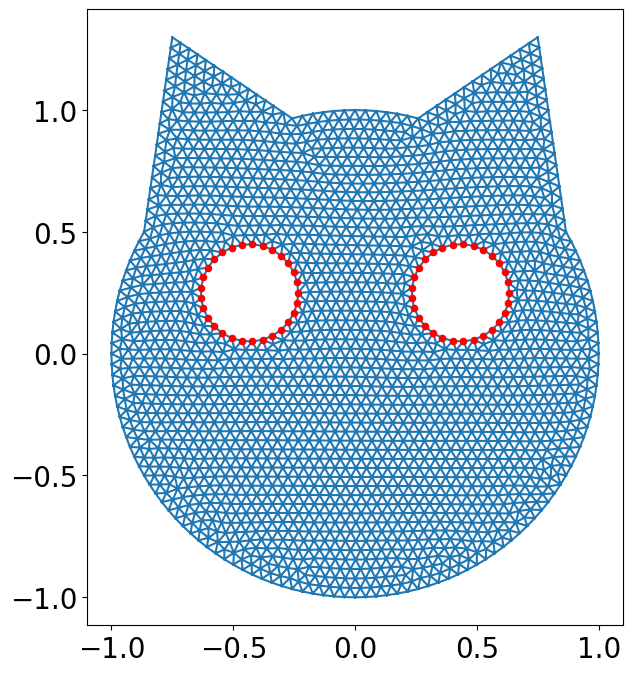

In [3]:
# find indices of mesh points on the Dirichlet boundary
right_eye_idx = []
tol = 1e-12
for j in range(Neye):
    k = np.argwhere((pts[:,0]-right_eye[j,0])**2 + (pts[:,1]-right_eye[j,1])**2 < tol)
    right_eye_idx.append(k)
right_eye_idx = np.squeeze(np.array(right_eye_idx)) 

print(right_eye_idx)

left_eye_idx = []
for j in range(Neye):    
    k = np.argwhere((pts[:,0]-left_eye[j,0])**2 + (pts[:,1]-left_eye[j,1])**2 < tol)
    left_eye_idx.append(k)
left_eye_idx = np.squeeze(np.array(left_eye_idx))

print(left_eye_idx)

dirichlet_bdry = np.concatenate((right_eye_idx,left_eye_idx))

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize = (8,8))
plt.triplot(pts[:,0],pts[:,1],tri)    
plt.scatter(pts[dirichlet_bdry,0],pts[dirichlet_bdry,1],s=20,c="red")  
ax.set_aspect('equal')
plt.savefig("CatHead.pdf")

In [4]:
# define finite element functions
def triarea2(verts):
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    return np.linalg.det(Aux)

def stima3(verts):
    Aux = np.ones((3,3))
    Aux[1:3,:] = np.transpose(verts)
    rhs = np.zeros((3,2))
    rhs[1,0] = 1
    rhs[2,1] = 1
    G = np.zeros((3,2))
    G[:,0] = np.linalg.solve(Aux,rhs[:,0])
    G[:,1] = np.linalg.solve(Aux,rhs[:,1])
    det = np.linalg.det(Aux)
    MA = 0.5*det*np.matmul(G,np.transpose(G))
    MB = det*np.array([[2,1,1],[1,2,1],[1,1,2]])/24
    return MA,MB

def InitialCondition(verts):
    return 10*np.exp(-4*((verts[:,0] + 0.7)**2 + (verts[:,1] - 1)**2))

def SourceFun(verts,t):
    return 0

In [5]:
# visualization
def visualize(pts,tri,u,str_title,str_file_name):
    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(figsize = (8,8))
    umax = np.max(u)
    umin = np.min(u)
    plt.tricontourf(pts[:,0], pts[:,1],tri,u,np.linspace(umin,umax,60))
    plt.colorbar()
    plt.title(str_title)
    ax.set_aspect('equal')
    ax.set(xlim=(-rad,rad), ylim=(-rad,rad_ear)) 
    plt.savefig(str_file_name)

Npts =  2123  Ntri =  4019


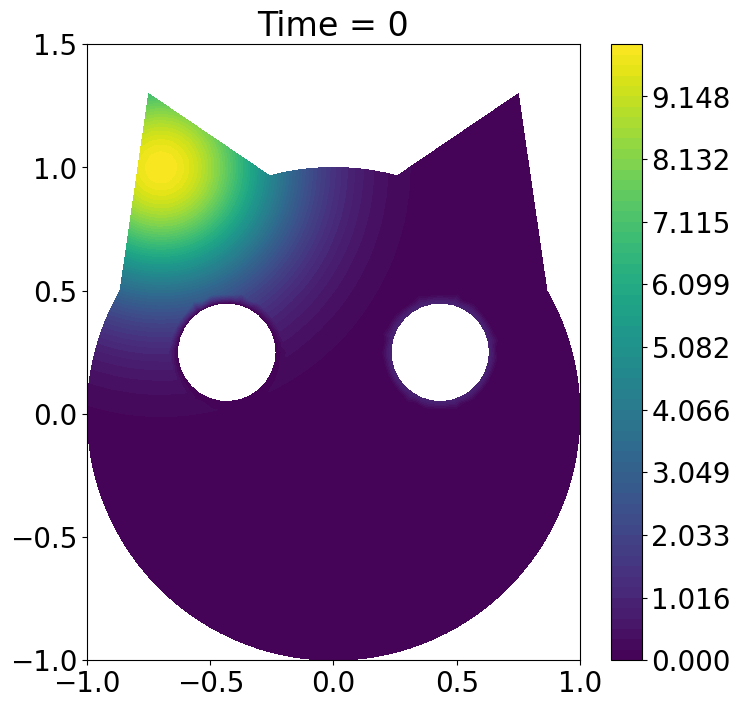

In [6]:
# FEM: Initialization
Npts = np.size(pts,axis=0) # the number of mesh points
Ntri = np.size(tri,axis=0) # the number of triangle
print("Npts = ",Npts," Ntri = ",Ntri)

free_nodes = np.setdiff1d(np.arange(0,Npts,1,dtype = int),dirichlet_bdry,assume_unique=True)

A = scipy.sparse.csr_matrix((Npts,Npts), dtype = float).toarray() # define the sparse matrix A
B = scipy.sparse.csr_matrix((Npts,Npts), dtype = float).toarray() # define the sparse matrix A
b = np.zeros((Npts,1)) # the right-hand side
u = InitialCondition(pts) # initial conditions
u[dirichlet_bdry] = 0 # Dirichlet boundary conditions
u[right_eye_idx] = 1

# stiffness matrix
for j in range(Ntri):
    v = pts[tri[j,:],:] # vertices of mesh triangle
    ind = tri[j,:]
    indt = np.array(ind)[:,None]
    MA,MB = stima3(v)
    A[indt,ind] = A[indt,ind] + MA
    B[indt,ind] = B[indt,ind] + MB
 
visualize(pts,tri,u,"Time = 0","fig0.pdf")

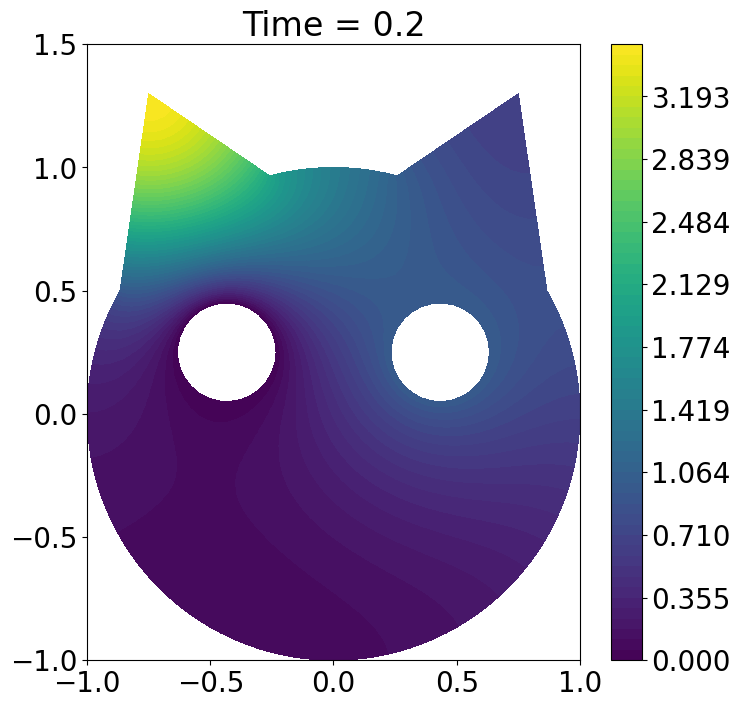

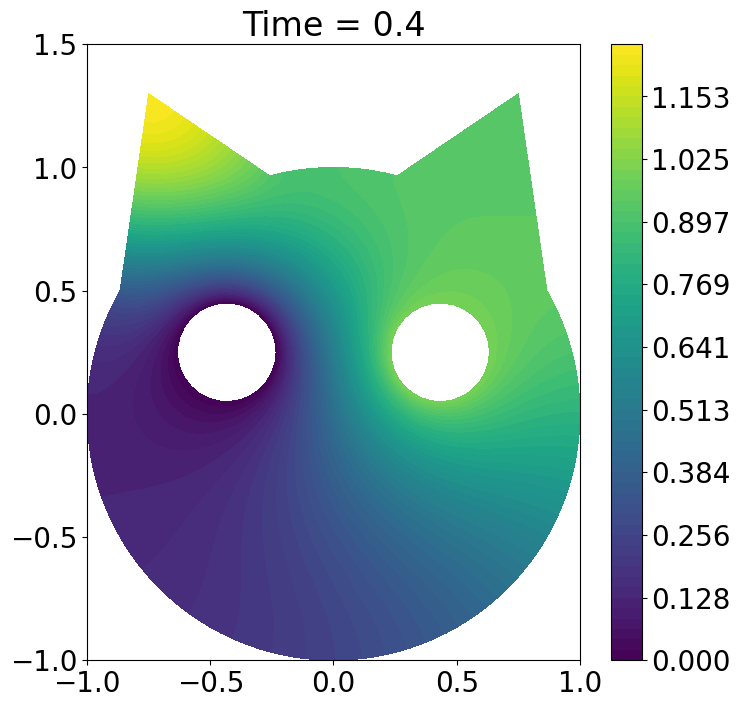

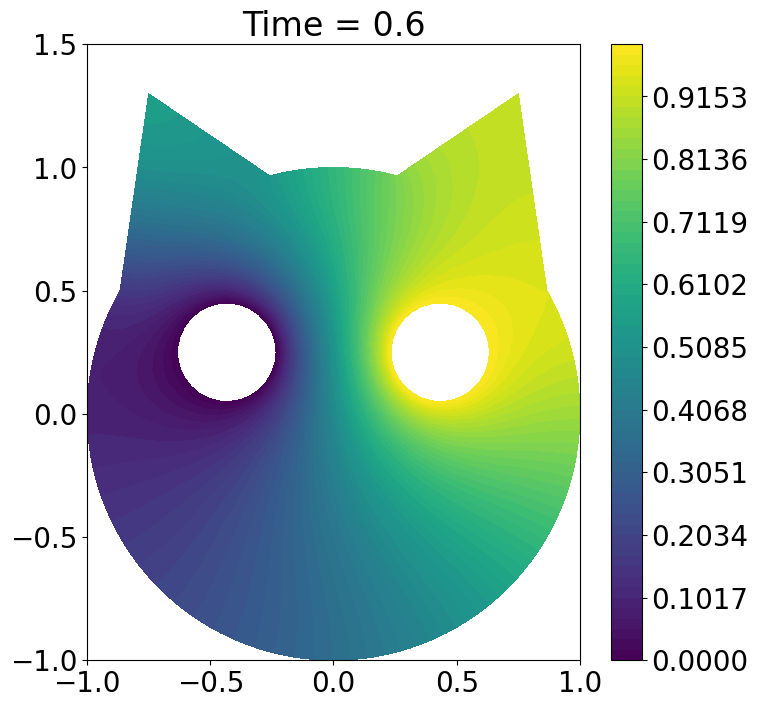

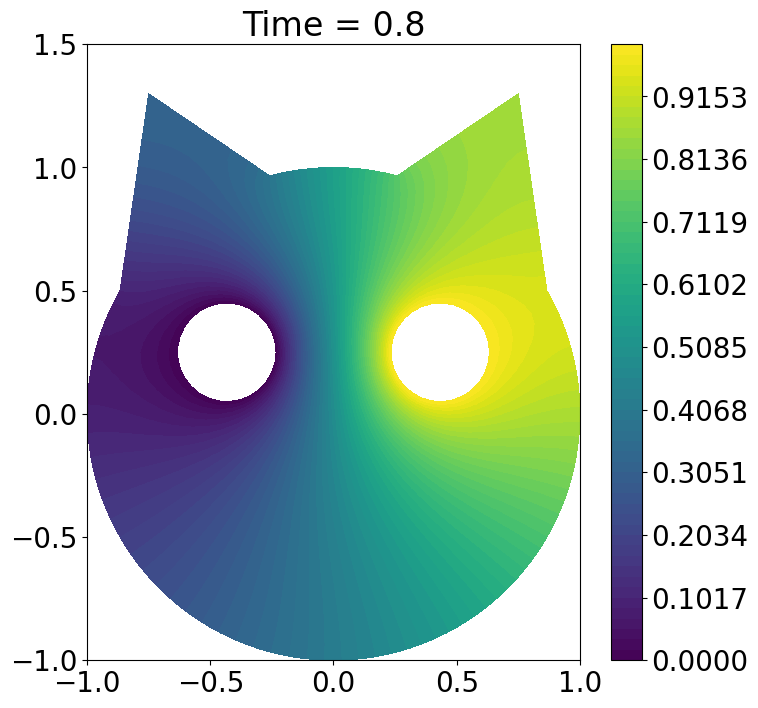

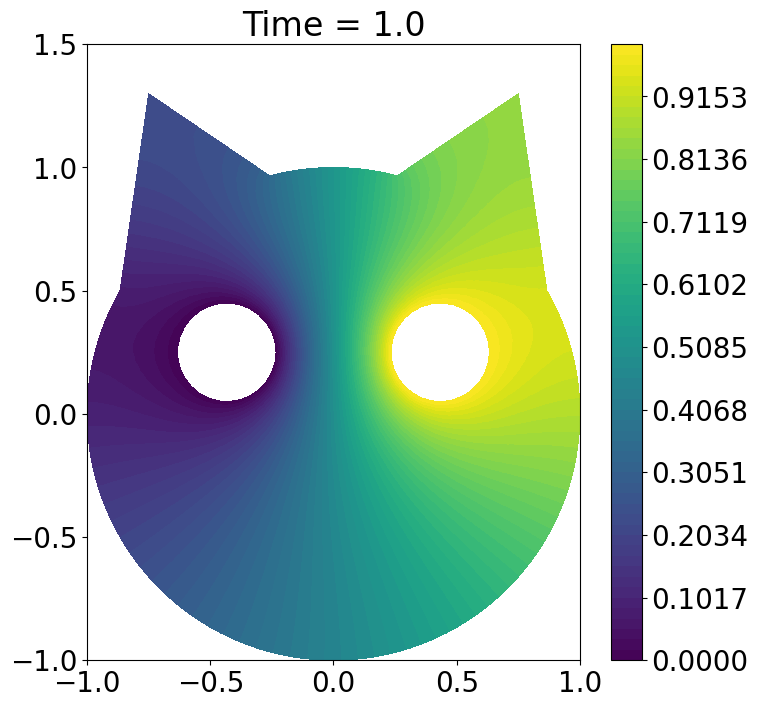

In [7]:
Tmax = 1.0
Nt = 101;
tvals = np.linspace(0,Tmax,Nt)
dt = tvals[1]-tvals[0]
tshow_step = 0.2
nshow = int(np.round(tshow_step/dt))

free_nodes_t = np.array(free_nodes)[:,None]
U = np.zeros((Npts,Nt))
U[:,0] = u



for n in range(1,Nt):
    u = np.zeros((Npts,))
    u[right_eye_idx] = 1
    b = np.zeros((Npts,))
    t = (n+1)*dt
    # Volume forces
    for j in range(Ntri):
        verts = pts[tri[j,:],:]
        b[tri[j,:]] = b[tri[j,:]] + dt*triarea2(verts)*SourceFun(np.mean(verts,axis = 0),t)/6
    # Add code for nonhomogeneous Neumann boundary conditions here
    b = b + np.matmul(B,U[:,n-1]) # 
    # Add code for nonhomogeneous Dirichlet boundary conditions here
    b = b - np.matmul(dt*A + B,u)
    # compute the solution on the next time step
    u[free_nodes] = scipy.linalg.solve(dt*A[free_nodes_t,free_nodes]+B[free_nodes_t,free_nodes],b[free_nodes])
    U[:,n] = u
    if np.mod(n,nshow) == 0:
        str_title = f'Time = {t:.1f}'
        fignum = int(np.round(t/tshow_step))
        str_fig = f'fig{fignum}.pdf'
        visualize(pts,tri,u,str_title,str_fig)
    
